In [1]:
import math
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.manifold import TSNE
import xgboost as xgb
from hyperopt import fmin, tpe, space_eval, hp, STATUS_OK, Trials
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras import Sequential
from keras.regularizers import l1, l2
from numpy.random import default_rng
import matplotlib.lines as mlines

%matplotlib inline

In [2]:
df = pd.read_csv('2020.1 - sysarmy - Encuesta de remuneración salarial Argentina - Argentina.csv', skiprows=9)
df = df[df['Salario mensual BRUTO (en tu moneda local)'] < 1_000_000]
df = df[df['Años en la empresa actual'] < 40]
df = df[(df['Salario mensual BRUTO (en tu moneda local)'] >= 10_000) & (df['Salario mensual BRUTO (en tu moneda local)'] <= 1_000_000)]
df = df.reset_index().drop('index', axis=1)
df.head()

,Me identifico,Tengo,Dónde estás trabajando,Años de experiencia,Años en la empresa actual,Años en el puesto actual,¿Gente a cargo?,Nivel de estudios alcanzado,Estado,Carrera,...,¿Tenés algún tipo de discapacidad?,¿Sentís que esto te dificultó el conseguir trabajo?,¿A qué eventos de tecnología asististe en el último año?,Cantidad de empleados,Actividad principal,¿La recomendás como un buen lugar para trabajar?,¿Cómo calificás las políticas de diversidad e inclusión?,¿A cuántos kilómetros de tu casa queda la oficina?,Beneficios extra,"¿Cuáles considerás que son las mejores empresas de IT para trabajar en este momento, en tu ciudad?"
0,Hombre,40,Catamarca,15.0,0.0,0.0,0,Universitario,Completado,Licenciatura en Sistemas de Información,...,NaN,NaN,NaN,201-500,Otras industrias,6,6,4.0,"Comidas pagas / subvencionadas, Estacionamient...",NaN
1,Mujer,35,Catamarca,15.0,10.0,3.0,5,Posgrado,Completado,Licenciatura en Sistemas de Información,...,NaN,No,NaN,11-50,Servicios / Consultoría de Software / Digital,5,8,2.0,Abono de celular y/o Internet,NaN
2,Hombre,39,Chaco,10.0,5.0,5.0,6,Universitario,Incompleto,Ingeniería en Sistemas de Información,...,NaN,NaN,Ekoparty,11-50,Servicios / Consultoría de Software / Digital,10,10,1.0,"Capacitaciones y/o cursos, Clases de idiomas, ...",NaN
3,Hombre,42,Chaco,18.0,3.0,3.0,0,Universitario,Completado,Licenciatura en Análisis de Sistemas,...,NaN,No,NaN,11-50,Producto basado en Software,5,3,-1.0,"Horarios flexibles, Sueldo dolarizado, WFH (Tr...",NaN
4,Hombre,29,Chaco,4.0,0.0,0.0,1,Universitario,Completado,Ingeniería Electrónica,...,NaN,NaN,"Pynea, Autodefensa digital",201-500,Otras industrias,8,9,5.0,"Abono de celular y/o Internet, Comidas pagas /...",NaN


In [3]:
def clean_row(row):
    d = {}
    for k, v in row.items():
        for word in clean_words(v):
            d[f'{k}={word}'] = 1
    return pd.Series(d, dtype='int')
    
def clean_words(value):
    value = value.replace('Microsoft Azure (Tables, CosmosDB, SQL, etc)', 'Microsoft Azure(TablesCosmosDBSQLetc)')
    value = value.replace('Snacks, golosinas, bebidas', 'snacks')
    value = value.replace('Descuentos varios (Clarín 365, Club La Nación, etc)', 'descuentos varios')
    value = value.replace('Sí, de forma particular', 'de forma particular')
    value = value.replace('Sí, los pagó un empleador', 'los pagó un empleador')
    value = value.replace('Sí, activa', 'activa')
    value = value.replace('Sí, pasiva', 'pasiva')
    return [clean_word(v) for v in value.split(',') if clean_word(v)]

def clean_word(word):
    val = str(word).lower().strip().replace(".", "")
    if val in ('ninguno', 'ninguna', 'no', '0', 'etc)', 'nan'):
        return ''
    if val == 'Microsoft Azure(TablesCosmosDBSQLetc)':
        return 'Microsoft Azure (Tables, CosmosDB, SQL, etc)'
    if val in ('pycon', 'pyconar'):
        return 'pyconar'
    if val in ('nodeconf', 'nodeconfar'):
        return 'nodeconfar'
    if val in ('meetup', 'meetups'):
        return 'meetups'
    if val == 'snacks':
        return 'snacks, golosinas, bebidas'
    if val == 'descuentos varios':
        return 'descuentos varios (clarín 365, club la nación, etc)'
    return val.replace(' ', '')

enc = OneHotEncoder(handle_unknown='ignore')
df_encoded = pd.concat((
pd.DataFrame(
enc.fit_transform(
        df[[
            'Me identifico',
            'Nivel de estudios alcanzado',
            'Universidad',
            'Estado',
            'Carrera',
            '¿Contribuís a proyectos open source?',
            '¿Programás como hobbie?',
            'Trabajo de',
            '¿Qué SO usás en tu laptop/PC para trabajar?',
            '¿Y en tu celular?',
            'Tipo de contrato',
            'Orientación sexual',
            'Cantidad de empleados',
            'Actividad principal',
        ]].fillna('')
    ).toarray()
)
,
df[[
    '¿Tenés guardias?',
    'Realizaste cursos de especialización',
    '¿A qué eventos de tecnología asististe en el último año?',
    'Beneficios extra',
    'Plataformas',
    'Lenguajes de programación',
    'Frameworks, herramientas y librerías',
    'Bases de datos',
    'QA / Testing',
    'IDEs',
    'Lenguajes de programación'
]].fillna('').apply(clean_row, axis=1).fillna(0),
df[['¿Gente a cargo?', 'Años de experiencia', 'Tengo', 'Salario mensual BRUTO (en tu moneda local)']],
), axis=1)
df_encoded

,0,1,2,3,4,5,6,7,8,9,...,¿A qué eventos de tecnología asististe en el último año?=zruput,¿A qué eventos de tecnología asististe en el último año?=ágiles,¿A qué eventos de tecnología asististe en el último año?=ágileslatam,¿A qué eventos de tecnología asististe en el último año?=ágileslatinoamerica,¿Tenés guardias?=activa,¿Tenés guardias?=pasiva,¿Gente a cargo?,Años de experiencia,Tengo,Salario mensual BRUTO (en tu moneda local)
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,15.0,40,41000.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,5,15.0,35,60000.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,6,10.0,39,180000.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,18.0,42,150000.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0,29,25200.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5761,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2,9.0,40,252450.0
5762,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,4.0,33,76000.0
5763,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1,4.0,26,39900.0
5764,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0,11.0,32,43000.0


In [4]:
X_train, X_test, y_train, y_test = train_test_split(df_encoded.drop('Salario mensual BRUTO (en tu moneda local)', axis=1), df['Salario mensual BRUTO (en tu moneda local)'], test_size=0.2, random_state=42)
X_train

,0,1,2,3,4,5,6,7,8,9,...,¿A qué eventos de tecnología asististe en el último año?=yc,¿A qué eventos de tecnología asististe en el último año?=zruput,¿A qué eventos de tecnología asististe en el último año?=ágiles,¿A qué eventos de tecnología asististe en el último año?=ágileslatam,¿A qué eventos de tecnología asististe en el último año?=ágileslatinoamerica,¿Tenés guardias?=activa,¿Tenés guardias?=pasiva,¿Gente a cargo?,Años de experiencia,Tengo
5233,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,20.0,46
4807,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,2.0,30
2057,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,14.0,33
3167,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,3.0,27
2759,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,8.0,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,29
5191,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,7.0,40
5226,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,5.0,33
5390,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,7.0,25


Epoch 1/50
73/73 [==============================] - 1s 16ms/step - loss: 7325231104.0000
Epoch 2/50
73/73 [==============================] - 1s 16ms/step - loss: 3735144448.0000
Epoch 3/50
73/73 [==============================] - 1s 17ms/step - loss: 3210683392.0000
Epoch 4/50
73/73 [==============================] - 1s 16ms/step - loss: 2842979072.0000
Epoch 5/50
73/73 [==============================] - 1s 17ms/step - loss: 2508090624.0000
Epoch 6/50
73/73 [==============================] - 1s 17ms/step - loss: 2370899200.0000
Epoch 7/50
73/73 [==============================] - 1s 17ms/step - loss: 2046515968.0000
Epoch 8/50
73/73 [==============================] - 1s 17ms/step - loss: 2000222336.0000
Epoch 9/50
73/73 [==============================] - 1s 17ms/step - loss: 1804063488.0000
Epoch 10/50
73/73 [==============================] - 1s 17ms/step - loss: 1780542720.0000
Epoch 11/50
73/73 [==============================] - 1s 17ms/step - loss: 1618578176.0000
Epoch 12/50
73/73 [

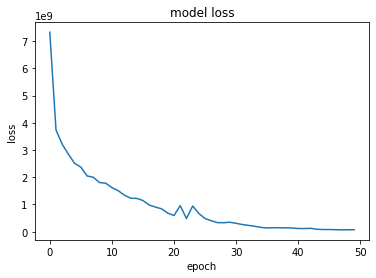

In [21]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dense(1000, activation="relu", name="layer1"),
        Dense(1000, activation="relu", name="layer2"),
        Dense(1000, activation="relu", name="layer3"),
        Dense(1000, activation="relu", name="layer4"),
        Dense(1, name="output"),
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam')
history = model.fit(
    np.asarray(X_train, dtype=np.float),
    np.asarray(y_train, dtype=np.float),
    batch_size=64,
    epochs=50,
);
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show();

In [22]:
r2_score(y_test, model.predict(np.asarray(X_test, dtype=np.float)))

0.3992176320910157

Epoch 1/50
73/73 [==============================] - 1s 18ms/step - loss: 6862192128.0000
Epoch 2/50
73/73 [==============================] - 1s 17ms/step - loss: 4111434240.0000
Epoch 3/50
73/73 [==============================] - 1s 18ms/step - loss: 3366066176.0000
Epoch 4/50
73/73 [==============================] - 1s 18ms/step - loss: 2972186368.0000
Epoch 5/50
73/73 [==============================] - 1s 18ms/step - loss: 2729525248.0000
Epoch 6/50
73/73 [==============================] - 1s 19ms/step - loss: 2484499200.0000
Epoch 7/50
73/73 [==============================] - 1s 18ms/step - loss: 2388969216.0000
Epoch 8/50
73/73 [==============================] - 1s 17ms/step - loss: 2406446592.0000
Epoch 9/50
73/73 [==============================] - 1s 17ms/step - loss: 2242754048.0000
Epoch 10/50
73/73 [==============================] - 1s 18ms/step - loss: 2110257408.0000
Epoch 11/50
73/73 [==============================] - 1s 18ms/step - loss: 2040373632.0000
Epoch 12/50
73/73 [

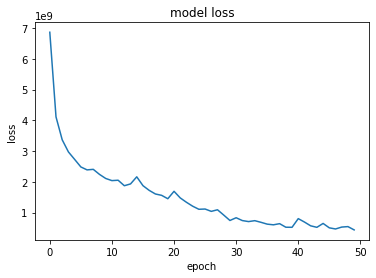

In [19]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dropout(0.1),
        Dense(1000, activation="relu", name="layer1"),
        Dropout(0.1),
        Dense(1000, activation="relu", name="layer2"),
        Dropout(0.1),
        Dense(1000, activation="relu", name="layer3"),
        Dropout(0.1),
        Dense(1000, activation="relu", name="layer4"),
        Dropout(0.1),
        Dense(1, name="output"),
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam')
history = model.fit(
    np.asarray(X_train, dtype=np.float),
    np.asarray(y_train, dtype=np.float),
    batch_size=64,
    epochs=50,
);
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show();

Epoch 1/50
73/73 [==============================] - 2s 27ms/step - loss: 6983767040.0000
Epoch 2/50
73/73 [==============================] - 2s 28ms/step - loss: 3750587392.0000
Epoch 3/50
73/73 [==============================] - 2s 28ms/step - loss: 3332449280.0000
Epoch 4/50
73/73 [==============================] - 2s 27ms/step - loss: 2955467008.0000
Epoch 5/50
73/73 [==============================] - 2s 27ms/step - loss: 2613847552.0000
Epoch 6/50
73/73 [==============================] - 2s 27ms/step - loss: 2394422016.0000
Epoch 7/50
73/73 [==============================] - 2s 27ms/step - loss: 2337549568.0000
Epoch 8/50
73/73 [==============================] - 2s 27ms/step - loss: 2364123136.0000
Epoch 9/50
73/73 [==============================] - 2s 27ms/step - loss: 2190335232.0000
Epoch 10/50
73/73 [==============================] - 2s 27ms/step - loss: 2070163456.0000
Epoch 11/50
73/73 [==============================] - 2s 27ms/step - loss: 2136648832.0000
Epoch 12/50
73/73 [

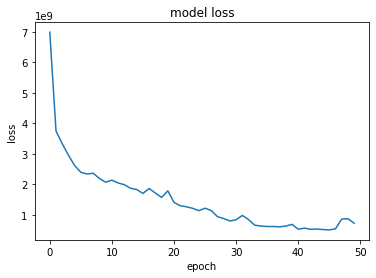

In [23]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dropout(0.1),
        Dense(2000, activation="relu", name="layer1"),
        Dropout(0.1),
        Dense(1000, activation="relu", name="layer2"),
        Dropout(0.1),
        Dense(500, activation="relu", name="layer3"),
        Dropout(0.1),
        Dense(250, activation="relu", name="layer4"),
        Dropout(0.1),
        Dense(1, name="output"),
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam')
history = model.fit(
    np.asarray(X_train, dtype=np.float),
    np.asarray(y_train, dtype=np.float),
    batch_size=64,
    epochs=50,
);
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show();

Epoch 1/50
73/73 [==============================] - 4s 52ms/step - loss: 5630518784.0000
Epoch 2/50
73/73 [==============================] - 4s 51ms/step - loss: 3332925696.0000
Epoch 3/50
73/73 [==============================] - 4s 51ms/step - loss: 3208044032.0000
Epoch 4/50
73/73 [==============================] - 4s 52ms/step - loss: 2601553152.0000
Epoch 5/50
73/73 [==============================] - 4s 51ms/step - loss: 2536129536.0000
Epoch 6/50
73/73 [==============================] - 4s 52ms/step - loss: 2513555456.0000
Epoch 7/50
73/73 [==============================] - 4s 52ms/step - loss: 2333179136.0000
Epoch 8/50
73/73 [==============================] - 4s 52ms/step - loss: 2050891648.0000
Epoch 9/50
73/73 [==============================] - 4s 52ms/step - loss: 2031252736.0000
Epoch 10/50
73/73 [==============================] - 4s 52ms/step - loss: 1868052480.0000
Epoch 11/50
73/73 [==============================] - 4s 53ms/step - loss: 1839222144.0000
Epoch 12/50
73/73 [

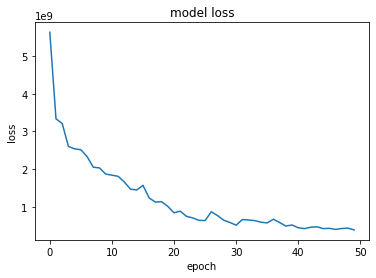

In [24]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dropout(0.1),
        Dense(2000, activation="relu", name="layer1"),
        Dropout(0.1),
        Dense(2000, activation="relu", name="layer2"),
        Dropout(0.1),
        Dense(2000, activation="relu", name="layer3"),
        Dropout(0.1),
        Dense(2000, activation="relu", name="layer4"),
        Dropout(0.1),
        Dense(1, name="output"),
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam')
history = model.fit(
    np.asarray(X_train, dtype=np.float),
    np.asarray(y_train, dtype=np.float),
    batch_size=64,
    epochs=50,
);
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show();

Epoch 1/50
73/73 [==============================] - 1s 16ms/step - loss: 6407872512.0000
Epoch 2/50
73/73 [==============================] - 1s 15ms/step - loss: 3528865792.0000
Epoch 3/50
73/73 [==============================] - 1s 15ms/step - loss: 2948519424.0000
Epoch 4/50
73/73 [==============================] - 1s 15ms/step - loss: 2764873472.0000
Epoch 5/50
73/73 [==============================] - 1s 15ms/step - loss: 3034429184.0000
Epoch 6/50
73/73 [==============================] - 1s 15ms/step - loss: 2398354432.0000
Epoch 7/50
73/73 [==============================] - 1s 15ms/step - loss: 2424463360.0000
Epoch 8/50
73/73 [==============================] - 1s 15ms/step - loss: 2196621056.0000
Epoch 9/50
73/73 [==============================] - 1s 15ms/step - loss: 2099822336.0000
Epoch 10/50
73/73 [==============================] - 1s 15ms/step - loss: 2109673472.0000
Epoch 11/50
73/73 [==============================] - 1s 15ms/step - loss: 1970954112.0000
Epoch 12/50
73/73 [

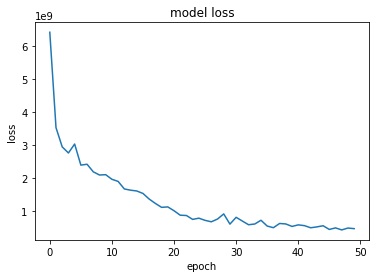

In [25]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dropout(0.1),
        Dense(800, activation="relu", name="layer1"),
        Dropout(0.1),
        Dense(800, activation="relu", name="layer2"),
        Dropout(0.1),
        Dense(800, activation="relu", name="layer3"),
        Dropout(0.1),
        Dense(800, activation="relu", name="layer4"),
        Dropout(0.1),
        Dense(800, activation="relu", name="layer5"),
        Dropout(0.1),
        Dense(1, name="output"),
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam')
history = model.fit(
    np.asarray(X_train, dtype=np.float),
    np.asarray(y_train, dtype=np.float),
    batch_size=64,
    epochs=50,
);
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show();

Epoch 1/50
73/73 [==============================] - 3s 47ms/step - loss: 6029492736.0000
Epoch 2/50
73/73 [==============================] - 3s 47ms/step - loss: 3633557248.0000
Epoch 3/50
73/73 [==============================] - 3s 46ms/step - loss: 3170785280.0000
Epoch 4/50
73/73 [==============================] - 3s 46ms/step - loss: 2748297728.0000
Epoch 5/50
73/73 [==============================] - 3s 47ms/step - loss: 2737297920.0000
Epoch 6/50
73/73 [==============================] - 3s 48ms/step - loss: 2515510784.0000
Epoch 7/50
73/73 [==============================] - 4s 48ms/step - loss: 2423305728.0000
Epoch 8/50
73/73 [==============================] - 3s 46ms/step - loss: 2286089728.0000
Epoch 9/50
73/73 [==============================] - 3s 46ms/step - loss: 2331208704.0000
Epoch 10/50
73/73 [==============================] - 3s 47ms/step - loss: 2028695808.0000
Epoch 11/50
73/73 [==============================] - 3s 47ms/step - loss: 2052370816.0000
Epoch 12/50
73/73 [

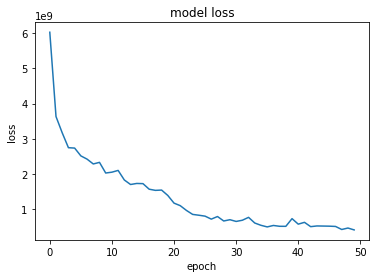

In [26]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dropout(0.1),
        Dense(2000, activation="relu", name="layer1"),
        Dropout(0.1),
        Dense(2000, activation="relu", name="layer2"),
        Dropout(0.1),
        Dense(2000, activation="relu", name="layer3"),
        Dropout(0.1),
        Dense(1000, activation="relu", name="layer4"),
        Dropout(0.1),
        Dense(1, name="output"),
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam')
history = model.fit(
    np.asarray(X_train, dtype=np.float),
    np.asarray(y_train, dtype=np.float),
    batch_size=64,
    epochs=50,
);
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show();

Epoch 1/50
73/73 [==============================] - 4s 52ms/step - loss: 13690736640.0000
Epoch 2/50
73/73 [==============================] - 4s 52ms/step - loss: 13676357632.0000
Epoch 3/50
73/73 [==============================] - 4s 53ms/step - loss: 13662294016.0000
Epoch 4/50
73/73 [==============================] - 4s 54ms/step - loss: 13648228352.0000
Epoch 5/50
73/73 [==============================] - 4s 54ms/step - loss: 13634115584.0000
Epoch 6/50
73/73 [==============================] - 4s 53ms/step - loss: 13620163584.0000
Epoch 7/50
73/73 [==============================] - 4s 52ms/step - loss: 13606225920.0000
Epoch 8/50
73/73 [==============================] - 4s 54ms/step - loss: 13592133632.0000
Epoch 9/50
73/73 [==============================] - 4s 53ms/step - loss: 13578137600.0000
Epoch 10/50
73/73 [==============================] - 4s 53ms/step - loss: 13564094464.0000
Epoch 11/50
73/73 [==============================] - 4s 55ms/step - loss: 13550062592.0000
Epoch 12

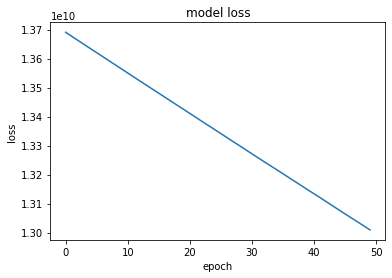

In [28]:
model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dropout(0.1),
        Dense(2000, activation="sigmoid", name="layer1"),
        Dropout(0.1),
        Dense(2000, activation="sigmoid", name="layer2"),
        Dropout(0.1),
        Dense(2000, activation="sigmoid", name="layer3"),
        Dropout(0.1),
        Dense(2000, activation="sigmoid", name="layer4"),
        Dropout(0.1),
        Dense(1, name="output"),
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam')
history = model.fit(
    np.asarray(X_train, dtype=np.float),
    np.asarray(y_train, dtype=np.float),
    batch_size=64,
    epochs=50,
);
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show();

Epoch 1/50
73/73 [==============================] - 4s 51ms/step - loss: 6158158848.0000
Epoch 2/50
73/73 [==============================] - 4s 52ms/step - loss: 3734024448.0000
Epoch 3/50
73/73 [==============================] - 4s 52ms/step - loss: 3003341568.0000
Epoch 4/50
73/73 [==============================] - 4s 51ms/step - loss: 2739796480.0000
Epoch 5/50
73/73 [==============================] - 4s 52ms/step - loss: 2461874688.0000
Epoch 6/50
73/73 [==============================] - 4s 52ms/step - loss: 2250457088.0000
Epoch 7/50
73/73 [==============================] - 4s 52ms/step - loss: 2525732352.0000
Epoch 8/50
73/73 [==============================] - 4s 53ms/step - loss: 2156454144.0000
Epoch 9/50
73/73 [==============================] - 4s 54ms/step - loss: 2037759616.0000
Epoch 10/50
73/73 [==============================] - 4s 53ms/step - loss: 1871849856.0000
Epoch 11/50
73/73 [==============================] - 4s 52ms/step - loss: 1759268992.0000
Epoch 12/50
73/73 [

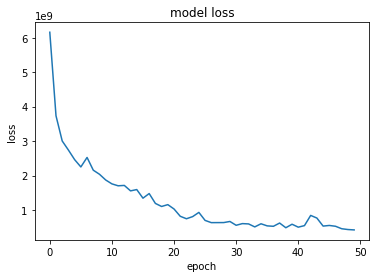

In [31]:
from keras.layers import LeakyReLU

model = Sequential(
    [
        Input(shape=(X_train.shape[1],)),
        Dropout(0.1),
        Dense(2000, LeakyReLU(alpha=0.05)),
        Dropout(0.1),
        Dense(2000, LeakyReLU(alpha=0.05)),
        Dropout(0.1),
        Dense(2000, LeakyReLU(alpha=0.05)),
        Dropout(0.1),
        Dense(2000, LeakyReLU(alpha=0.05)),
        Dropout(0.1),
        Dense(1, name="output"),
    ]
)
model.compile(loss='mean_squared_error', optimizer='Adam')
history = model.fit(
    np.asarray(X_train, dtype=np.float),
    np.asarray(y_train, dtype=np.float),
    batch_size=64,
    epochs=50,
);
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show();